In [1]:
!pip install -U -q fcapy==0.1.4

# General Pipeline

## Formal Context
(Binary data)

Load a FormalContext $K$

In [2]:
!wget -q https://raw.githubusercontent.com/EgorDudyrev/FCApy/main/data/animal_movement.csv

from fcapy.context import FormalContext
K = FormalContext.read_csv('animal_movement.csv')

!rm animal_movement.csv

print('# objects', K.n_objects, '; # attributes', K.n_attributes)
K[:5]

# objects 16 ; # attributes 4


FormalContext (5 objects, 4 attributes, 7 connections)
     |fly|hunt|run|swim|
dove |  X|    |   |    |
hen  |   |    |   |    |
duck |  X|    |   |   X|
goose|  X|    |   |   X|
owl  |  X|   X|   |    |

Create a ConceptLattice $L$ out of the context $K$

In [3]:
from fcapy.lattice import ConceptLattice
L = ConceptLattice.from_context(K)
print("# concepts:", len(L))

# concepts: 8


Draw the lattice $L$

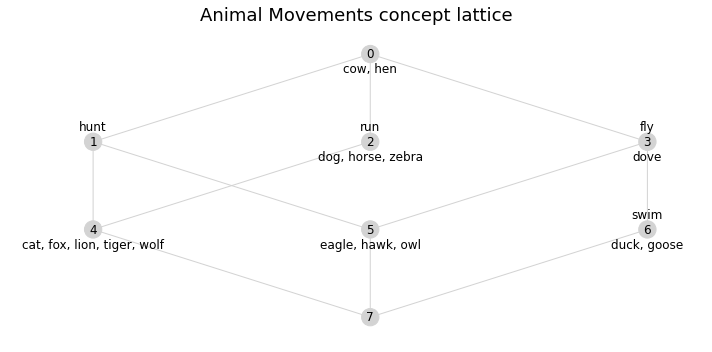

In [4]:
import matplotlib.pyplot as plt
from fcapy.visualizer import LineVizNx

fig, ax = plt.subplots(figsize=(10,5))
vsl = LineVizNx()
vsl.draw_concept_lattice(
    L, ax=ax, flg_node_indices=True,
    max_new_extent_count=10, flg_new_intent_count_prefix=False, flg_new_extent_count_prefix=False
)
ax.set_xlim(ax.get_xlim()[0]-0.05, ax.get_xlim()[1])
plt.title('Animal Movements concept lattice', size=18)
plt.tight_layout()
plt.show()

Or access each concept by its index

In [5]:
i = 2
c = L[i]
print(f"Concept {i}:\nextent {c.extent}\nintent {c.intent}")

Concept 2:
extent ('fox', 'dog', 'wolf', 'cat', 'tiger', 'lion', 'horse', 'zebra')
intent ('run',)


In [6]:
for i, c in enumerate(L):
    print(f"Concept {i}:\nextent {c.extent}\nintent {c.intent}\n")

Concept 0:
extent ('dove', 'hen', 'duck', 'goose', 'owl', 'hawk', 'eagle', 'fox', 'dog', 'wolf', 'cat', 'tiger', 'lion', 'horse', 'zebra', 'cow')
intent ()

Concept 1:
extent ('owl', 'hawk', 'eagle', 'fox', 'wolf', 'cat', 'tiger', 'lion')
intent ('hunt',)

Concept 2:
extent ('fox', 'dog', 'wolf', 'cat', 'tiger', 'lion', 'horse', 'zebra')
intent ('run',)

Concept 3:
extent ('dove', 'duck', 'goose', 'owl', 'hawk', 'eagle')
intent ('fly',)

Concept 4:
extent ('fox', 'wolf', 'cat', 'tiger', 'lion')
intent ('hunt', 'run')

Concept 5:
extent ('owl', 'hawk', 'eagle')
intent ('fly', 'hunt')

Concept 6:
extent ('duck', 'goose')
intent ('fly', 'swim')

Concept 7:
extent ()
intent ('fly', 'hunt', 'run', 'swim')



## ManyValuedContext
(NonBinary data)

The same can be done for nonbinary data:

In [7]:
from sklearn.datasets import load_iris
X, y = load_iris(as_frame=True, return_X_y=True)

In [8]:
from fcapy.mvcontext import MVContext, pattern_structure as PS

ptypes = {str(f): PS.IntervalPS for f in X}
mvK = MVContext(
    X.values, ptypes,
    object_names=('g'+X.index.astype(str)).tolist(),
    attribute_names=X.columns.tolist()
)
print('# objects', mvK.n_objects, '; # attributes', mvK.n_attributes)

# objects 150 ; # attributes 4


We will use our implementation of Sofia algorithm to find a hundred of the most stable concepts. The total number of concepts in the dataset can be on the order of thousands or even hundreds of thousands.

In [9]:
%%time
L_mv = ConceptLattice.from_context(mvK, algo='Sofia', L_max=100)
print(len(L_mv))

86
CPU times: user 43.5 s, sys: 31.3 ms, total: 43.5 s
Wall time: 43.6 s


In [10]:
indexes = [0, 1, 2]
for i, c in zip(indexes, L_mv[indexes]):
    ext_verb = ', '.join(c.extent[:10]) + ('...' if len(c.extent)>10 else '')
    int_verb = '\n\t'.join([f"{k}: {v}" for k,v in c.intent.items()])
    print(f"Concept {i}:\nextent {ext_verb}\nintent {int_verb}\n")

Concept 0:
extent g0, g1, g2, g3, g4, g5, g6, g7, g8, g9...
intent sepal length (cm): (4.3, 7.9)
	sepal width (cm): (2.0, 4.4)
	petal length (cm): (1.0, 6.9)
	petal width (cm): (0.1, 2.5)

Concept 1:
extent g0, g1, g2, g3, g4, g5, g6, g7, g8, g9...
intent sepal length (cm): (4.3, 7.7)
	sepal width (cm): (2.0, 4.4)
	petal length (cm): (1.0, 6.9)
	petal width (cm): (0.1, 2.5)

Concept 2:
extent g0, g1, g2, g3, g4, g5, g6, g7, g8, g9...
intent sepal length (cm): (4.3, 7.9)
	sepal width (cm): (2.0, 4.4)
	petal length (cm): (1.0, 6.7)
	petal width (cm): (0.1, 2.5)



# High level API

A concept can be added or removed from a lattice:

In [11]:
L = ConceptLattice.from_context(K)
print('Initial size of a lattice:', len(L))

c = L[4]
L.remove_concept(4)
print('Size after deletion:', len(L))

L.add_concept(c)
print('Size after addition:', len(L))

L_true = ConceptLattice.from_context(K)
print('The add-removed lattice is the same as before:', L==L_true, '\n')
print('// Although the indices of elements have changed:\n\t',
      ', '.join([f"{c_i} -> {L.index(c)}" for c_i, c in enumerate(L_true)]))

Initial size of a lattice: 8
Size after deletion: 7
Size after addition: 8
The add-removed lattice is the same as before: True 

// Although the indices of elements have changed:
	 0 -> 0, 1 -> 1, 2 -> 2, 3 -> 3, 4 -> 7, 5 -> 4, 6 -> 5, 7 -> 6


The neighbours of a specific concept can be obtained as follows:

In [12]:
i = 4

# direct subconcepts (children) of the fourth concept
a, b, c = L.direct_sub_elements(element_index=i), L.direct_sub_elements_dict[i], L.subconcepts_dict[i]
assert a==b==c

# direct superconcepts (parents) of the fourth concept
a, b, c = L.direct_super_elements(element_index=i), L.direct_super_elements_dict[i], L.superconcepts_dict[i]
assert a==b==c

# all subconcepts (descendants) of the fourth concept
a, b, c = L.sub_elements(element_index=i), L.sub_elements_dict[i], L.all_subconcepts_dict[i]
assert a==b==c

# all superconcepts (ancestors) of the fourth concept
a, b, c = L.super_elements(element_index=i), L.super_elements_dict[i], L.all_superconcepts_dict[i]
assert a==b==c